In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import matplotlib

# mount google drive to retrieve files
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Desai Lab'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Desai Lab'
/content/drive/My Drive/Desai Lab


## Find K_d and Plot Binding Curve

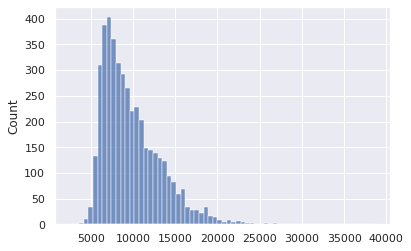

In [ ]:
sample_info = pd.DataFrame()

sample_info["filename"] = [file for file in glob(f"*_Comp-FITC*.csv") if "15-MAR" in file or "16-MAR" in file]
sample_info["well_id"] = sample_info.filename.str[0:3]
sample_info["date"] = sample_info.filename.str[17:28]
sample_info["PEs"] = sample_info.filename.apply(lambda x: pd.read_csv(x)["PE-A"].to_list())
# sample_info["PEs"] = sample_info.filename.apply(lambda x: pd.read_csv(x)["PE-A"].to_list())
sample_info.sort_values(by=["date", "well_id"], inplace=True)
# sample_info = sample_info.drop([0, 10, 20])
sample_info.reset_index(inplace=True, drop=True)
_ = sns.histplot(sample_info['PEs'][0])

# print(sample_info.to_string())

In [ ]:
def get_PEstats(row):
  try:
    minPE = np.min(row["PEs"])
    logPEs = np.log10(row["PEs"] - minPE + 1)
    meanPE = np.mean(logPEs)
    stdPE = np.std(logPEs)

  except ValueError:
    pass

  try:
    return logPEs, meanPE, stdPE
  except UnboundLocalError:
    return np.nan

sample_info[["log_PEs", "meanlog_PE", "stdlog_PE"]] = sample_info.apply(lambda x: get_PEstats(x), axis=1, result_type='expand')


# print(sample_info.loc[sample_info["well_id"]=="A05", "PEs"].to_list()[0][45])
# print(sample_info.to_string())

def label_conc(row):
  if int(row["well_id"][1:3]) <= 6:
    return -1*(int(row["well_id"][1:3]) + 6)
  elif int(row["well_id"][1:3]) == 7:
    return 0


sample_info["log_conc"] = sample_info.apply(lambda x: label_conc(x), axis=1)

#print(sample_info)

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import logsumexp

def titration_fluor(conc_ag, num_ab, kd, bg_fluor):
  # pe = sat*conc/(kd + conc)
  med_f = num_ab*(10**conc_ag)/(10**conc_ag + 10**kd) + bg_fluor
  return np.log10(med_f)

def fit_binding_curve(sample_id, ax):
  sample_info_dict = {1: sample_info[0:6], 2: sample_info[9:15], 3: sample_info[18:24], 4: sample_info[27:33], 5: sample_info[36:42],
                      6: sample_info[44:50], 7: sample_info[53:59], 8: sample_info[62:68], 9: sample_info[71:77]}
  sample_mutation_dict = {1: "Reaction 1: K417N", 2: "Reaction 2: S477N", 3: "Reaction 3: T478K", 4: "Reaction 4: E484A", 5: "Reaction 5: Q498R",
                          6: "Reaction 6: N501Y", 7: "Reaction 7: Q498R, N501Y", 8: "Reaction 8: E484A, Q498R", 9: "Reaction 9: K417N, E484A, Q498R, N501Y"}

  literature_Kd = {1: 7.82e-09, 2: 1.05e-9, 3: 2.28e-9, 4: 1, 5: 4.06e-9, 6: 5e-10, 7: 1, 8: 1, 9: 1}
  xdata = sample_info_dict[sample_id]["log_conc"].to_numpy()
  ydata = sample_info_dict[sample_id]["meanlog_PE"].to_numpy()
  stdPE = sample_info_dict[sample_id]["stdlog_PE"].to_numpy()

  popt, pcov = curve_fit(titration_fluor, xdata, ydata, sigma=stdPE, absolute_sigma=True, p0=[10**4, float(-9), 10**1], bounds = [(1,-16,1),(10**6,-5,10**6)], maxfev=400000)
  # popt, pcov = curve_fit(titration_curve, xdata, ydata, sigma=stdPE, absolute_sigma=True, p0=[10**4, float(-9), 10**1], maxfev=400000)

  xval = np.linspace(-12, -7, 50)
  yval = titration_fluor(xval, *popt)
  curve = sns.lineplot(x=xval, y=yval, label='fit', ax=ax)
  sns.scatterplot(x=xdata, y=ydata, label='data', color='orange', ax=ax)
  ax.errorbar(xdata, ydata, yerr=stdPE, fmt="none")

  # plot measured Kd
  ax.axvline(x=popt[1], color="red", linestyle="-.", label="$log_{10}$" +  " $K_d$ (variant)".format(popt[1]))

  # plot literature Kd
  # log_lit_kd = np.log10(literature_Kd[sample_id])
  # ax.axvline(x=log_lit_kd, color="green", linestyle="-.", label="$log_{10}$" +  " Lit. $K_d$".format(log_lit_kd))

  curve.set_xlabel("$log_{10}[ACE2]$")
  curve.set_ylabel("$log_{10}PE$")
  curve.set_title(sample_mutation_dict[sample_id])
  curve.set_yticks(np.linspace(2, 4, 5))
  curve.set_xticks(np.linspace(-12, -7, 6))
  curve.set_xlim([-12.25, -6.75])

  handles, labels = ax.get_legend_handles_labels()

  ax.legend().remove()

  # ax.legend((handles[1], handles[2],), (labels[1], labels[2],))
  # ax.annotate("Exp. $K_d$ = {0:.3f}\nLit. $K_d$ = {1:.3f}".format(popt[1], log_lit_kd),
  #           xy=(-11, 3.65),
  #           xycoords='data',
  #           bbox=dict(boxstyle='round', fc='0.95', edgecolor='silver'),   # New param
  #           ha='center',
  #           va='center',
  #           fontsize=10)

  ax.annotate("$log_{{10}}$ $K_d$ = {0:.3f}".format(popt[1]),
          xy=(-11.1, 3.75),
          xycoords='data',
          bbox=dict(boxstyle='round', fc='0.95', edgecolor='silver'),   # New param
          ha='center',
          va='center',
          fontsize=10)

  return (sample_mutation_dict[sample_id][12:], popt[1]), popt, pcov #kD, popt, pcov


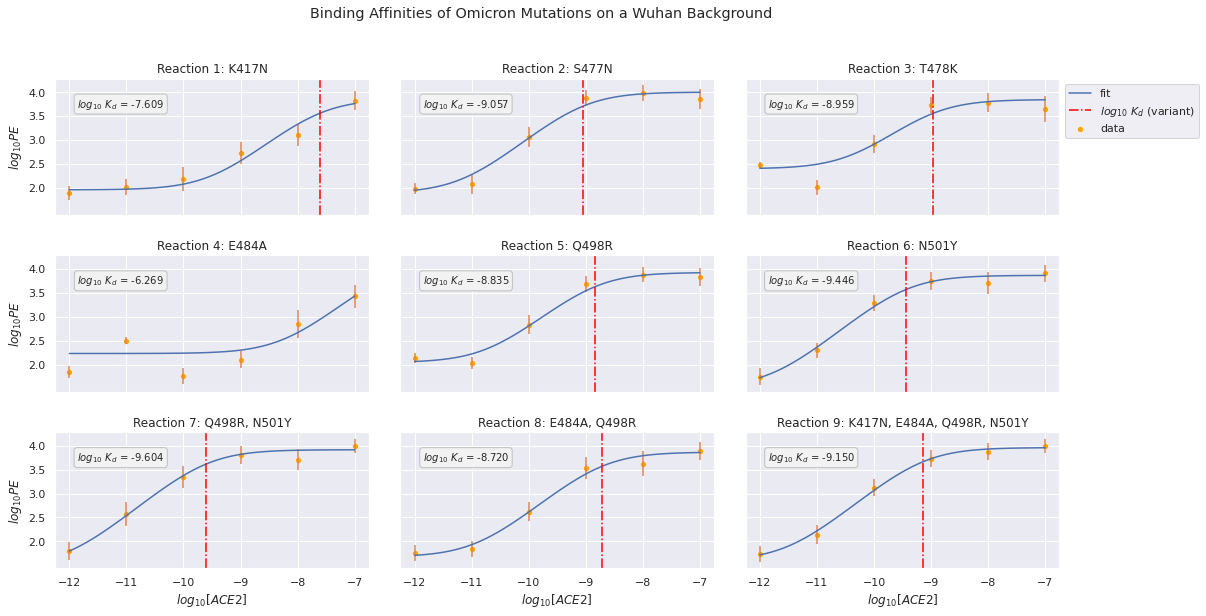

In [ ]:
sns.set(style="darkgrid", font_scale=1)
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(18,10))
plt.subplots_adjust(hspace=0.3, wspace=0.1, bottom=0.2)
ax = ax.flatten()

logkd_list = []

for i in range(1, 10):
  logkd_list.append(fit_binding_curve(i, ax[i-1])[0])

ax[2].legend(bbox_to_anchor=(1, 1))
plt.suptitle("Binding Affinities of Omicron Mutations on a Wuhan Background")
sns.set_context("poster")
plt.savefig("omicron_variant_binding.png", dpi=600, bbox_inches='tight')

## Plot Effects

[-1.080883101432871, 0.3665704384594548, 0.2694990906930741, -2.421322117826965, 0.14458123488352648, 0.7560771976696543, 0.9142773884749538, 0.030217873795242767, 0.4596849604800557] ['K417N', 'S477N', 'T478K', 'E484A', 'Q498R', 'N501Y', 'Q498R, N501Y', 'E484A, Q498R', 'K417N, E484A, Q498R, N501Y']


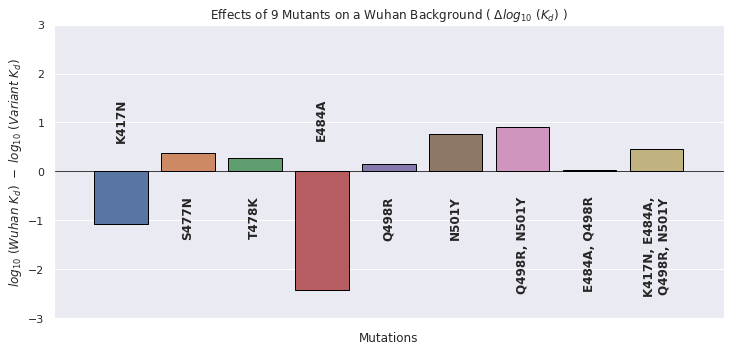

In [ ]:
sns.set(style="darkgrid", font_scale=1)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12,6))
plt.subplots_adjust(hspace=0.3, wspace=0.1, bottom=0.2)

kd_effects = [-8.69 - x[1] for x in logkd_list]
mutations = [x[0] for x in logkd_list]

print(kd_effects, mutations)

sns.barplot(x=mutations, y=kd_effects, edgecolor="black", ax=ax)
ax.axhline(0, color="black", linewidth=0.75)
ax.set_xticklabels([])
ax.set_ylim([-3, 3])
ax.set_xlim([-1, 9])

rects = ax.patches
for rect, mutation in zip(rects[:-1], mutations[:-1]):
    height = rect.get_height()
    if height > 0:
      ax.text(
          rect.get_x() + rect.get_width() / 2, -0.5, mutation, ha="center", va="top", rotation=90, weight="bold")
    elif height < 0:
      ax.text(
          rect.get_x() + rect.get_width() / 2, 1.5, mutation, ha="center", va="top", rotation=90, weight="bold")

ax.text(rects[-1].get_x() + rects[-1].get_width() / 2, -0.5, "K417N, E484A,\nQ498R, N501Y", ha="center", va="top", rotation=90, weight="bold")

# sns.despine()
# ax.spines['bottom'].set_visible(False)

plt.title("Effects of 9 Mutants on a Wuhan Background ( $\Delta log_{10}\ (K_d)$ )")
ax.set_ylabel("$log_{10}\ (Wuhan\ K_d)\ -\ log_{10}\ (Variant\ K_d)$")
ax.set_xlabel("Mutations")
plt.savefig("mutant_effects.png", dpi=600)

['Q498R, N501Y', 'E484A, Q498R', 'K417N, E484A, Q498R, N501Y']
-0.4 Q498R, N501Y
0.6000000000000001 E484A, Q498R
1.6 K417N, E484A, Q498R, N501Y
-2.7755575615628914e-17 Q498R, N501Y
0.9999999999999999 E484A, Q498R
2.0 K417N, E484A, Q498R, N501Y


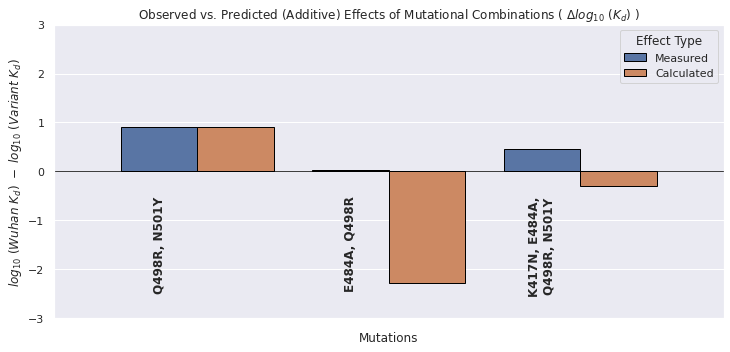

In [ ]:
sns.set(style="darkgrid", font_scale=1)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12,6))
plt.subplots_adjust(hspace=0.3, wspace=0.1, bottom=0.2)

print(mutations[-3:])

combo_effects = kd_effects[-3:]
combo_muts = mutations[-3:]
combo_muts.extend(mutations[-3:])
combo_effects.extend([kd_effects[4] + kd_effects[5], kd_effects[3] + kd_effects[4],
                 kd_effects[0] + kd_effects[5] + kd_effects[7]])

meas_add = ["Measured", "Measured", "Measured", "Calculated", "Calculated", "Calculated"]

mutant_frame = pd.DataFrame({"Mutation": combo_muts, "Effect": combo_effects, "Effect Type": meas_add})

sns.barplot(x="Mutation", y="Effect", hue="Effect Type", data=mutant_frame, edgecolor="black", ax=ax)
ax.axhline(0, color="black", linewidth=0.75)
ax.set_xticklabels([])
ax.set_ylim([-3, 3])
ax.set_xlim([-0.75, 2.75])

rects = ax.patches
i = 0
for rect, mutation in zip(rects, combo_muts):
    height = rect.get_height()
    print(rect.get_x(), mutation)
    if i==0 or i==1:
      if height > 0:
        ax.text(
            rect.get_x() + rect.get_width() / 2, -0.5, mutation, ha="center", va="top", rotation=90, weight="bold")
      elif height < 0:
        ax.text(
            rect.get_x() + rect.get_width() / 2, 2.5, mutation, ha="center", va="top", rotation=90, weight="bold")
    i+=1
#ax.text(rects[-1].get_x() + rects[-1].get_width() / 2, 2.5, "K417N, E484A,\nQ498R, N501Y", ha="center", va="top", rotation=90, weight="bold")
ax.text(rects[2].get_x() + rects[2].get_width() / 2, -0.5, "K417N, E484A,\nQ498R, N501Y", ha="center", va="top", rotation=90, weight="bold")


# sns.despine()
# ax.spines['bottom'].set_visible(False)

plt.title("Observed vs. Predicted (Additive) Effects of Mutational Combinations ( $\Delta log_{10}\ (K_d)$ )")
ax.set_ylabel("$log_{10}\ (Wuhan\ K_d)\ -\ log_{10}\ (Variant\ K_d)$")
ax.set_xlabel("Mutations")
plt.savefig("mutant_additive_effects.png", dpi=600)

## Plot Expression

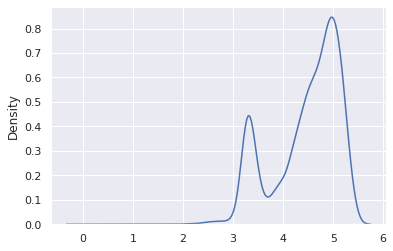

In [ ]:
def get_FITCstats(row):
  try:
    minFITC = np.min(row["FITC"])
    logFITC = np.log10(row["FITC"] - minFITC + 1)
    meanFITC = np.mean(logFITC)
    stdFITC = np.std(logFITC)

  except ValueError:
    pass

  try:
    return logFITC, meanFITC, stdFITC
  except UnboundLocalError:
    return np.nan

exp_info = pd.DataFrame()

exp_info["filename"] = glob(f"ungated*14-MAR-2022*.csv")
exp_info["well_id"] = exp_info.filename.str[8:11]
exp_info["FITC"] = exp_info.filename.apply(lambda x: pd.read_csv(x)["FITC-A"].to_list())
exp_info[["log_FITC", "meanlog_FITC", "stdlog_FITC"]] = exp_info.apply(lambda x: get_FITCstats(x), axis=1, result_type='expand')

exp_info.sort_values(by=["well_id"], inplace=True)
exp_info.reset_index(inplace=True, drop=True)

_ = sns.kdeplot(exp_info["log_FITC"][0])

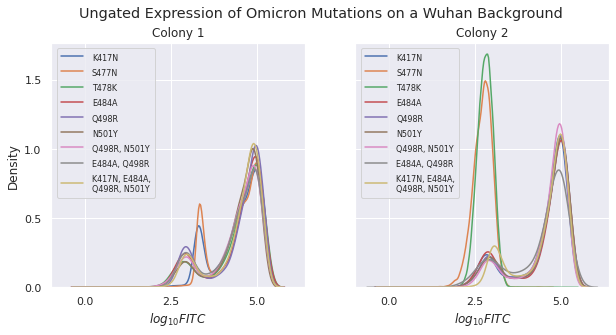

In [ ]:
sns.set(style="darkgrid", font_scale=1)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
plt.subplots_adjust(hspace=0.3, wspace=0.2, bottom=0.2)

sample_mutation_dict = {1: "Reaction 1: K417N", 2: "Reaction 2: S477N", 3: "Reaction 3: T478K", 4: "Reaction 4: E484A", 5: "Reaction 5: Q498R",
                          6: "Reaction 6: N501Y", 7: "Reaction 7: Q498R, N501Y", 8: "Reaction 8: E484A, Q498R", 9: "Reaction 9: K417N, E484A,\nQ498R, N501Y"}

# colony 1
for i in range(0, 9):
  kernel = sns.kdeplot(exp_info.iloc[i]["log_FITC"], ax=ax[0], label="{0}".format(sample_mutation_dict[i+1][12:]))
  kernel.set_xlabel("$log_{10} FITC$")

# colony 2
for i in range(10, 19):
  kernel = sns.kdeplot(exp_info.iloc[i]["log_FITC"], ax=ax[1], label="{0}".format(sample_mutation_dict[i-9][12:]))
  kernel.set_xlabel("$log_{10} FITC$")

ax[0].legend()
ax[1].legend()
plt.setp(ax[0].get_legend().get_texts(), fontsize='8')
plt.setp(ax[1].get_legend().get_texts(), fontsize='8')
ax[0].set_title("Colony 1")
ax[1].set_title("Colony 2")


plt.suptitle("Ungated Expression of Omicron Mutations on a Wuhan Background")
sns.set_context("poster")

plt.savefig("ungated_expression.png", dpi=600)
# print(exp_info.to_string())

Text(0.5, 0.98, 'Fraction of FITC+ Cells in 9 Omicron Mutants')

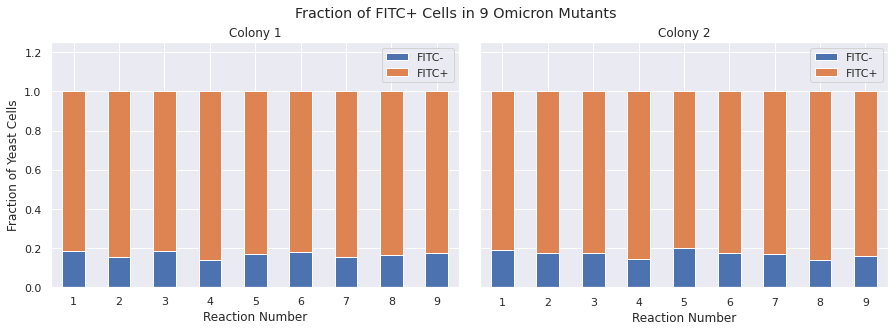

In [ ]:
exp_fraction = pd.read_csv("gated_fraction_expressed.csv", header=0, usecols=[1,2,3],
                           names=["well_id", "count_FITC-", "count_FITC+"],
                           dtype={"well_id": str, "count_FITC-": float, "count_FITC+": float})

exp_fraction["frac_FITC-"] = exp_fraction.apply(lambda x: x["count_FITC-"] / (x["count_FITC-"] + x["count_FITC+"]), axis=1)
exp_fraction["frac_FITC+"] = exp_fraction.apply(lambda x: x["count_FITC+"] / (x["count_FITC-"] + x["count_FITC+"]), axis=1)

# print(exp_fraction.to_string())

sns.set()
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
plt.subplots_adjust(hspace=0.3, wspace=0.05, bottom=0.2)

exp_fraction[["frac_FITC-", "frac_FITC+"]][0:9].plot(kind="bar", stacked=True, ax=ax[0], ylim=[0,1.25])
exp_fraction[["frac_FITC-", "frac_FITC+"]][9:18].plot(kind="bar", stacked=True, ax=ax[1], ylim=[0,1.25])

_ = ax[0].set_xticklabels(np.arange(1,10), rotation=0)
_ = ax[1].set_xticklabels(np.arange(1,10), rotation=1)
ax[0].set_xlabel("Reaction Number")
ax[1].set_xlabel("Reaction Number")
ax[0].set_ylabel("Fraction of Yeast Cells")
ax[0].set_title("Colony 1")
ax[1].set_title("Colony 2")
ax[0].legend(["FITC-", "FITC+"])
ax[1].legend(["FITC-", "FITC+"])
plt.suptitle("Fraction of FITC+ Cells in 9 Omicron Mutants")

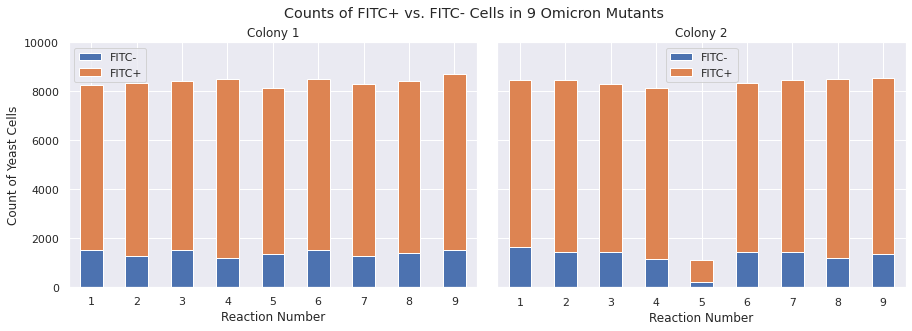

In [ ]:
# change to downsampled values for A1, A3, A11

exp_fraction.at[0, "count_FITC+"] = 6752
exp_fraction.at[0, "count_FITC-"] = 1508

exp_fraction.at[2, "count_FITC+"] = 6901
exp_fraction.at[2, "count_FITC-"] = 1539

exp_fraction.at[18, "count_FITC+"] = 8
exp_fraction.at[18, "count_FITC-"] = 7387


sns.set()
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
plt.subplots_adjust(hspace=0.3, wspace=0.05, bottom=0.2)

exp_fraction[["count_FITC-", "count_FITC+"]][0:9].plot(kind="bar", stacked=True, ax=ax[0], ylim=[0,10000])
exp_fraction[["count_FITC-", "count_FITC+"]][9:18].plot(kind="bar", stacked=True, ax=ax[1], ylim=[0,10000])

_ = ax[0].set_xticklabels(np.arange(1,10), rotation=0)
_ = ax[1].set_xticklabels(np.arange(1,10), rotation=1)
ax[0].set_xlabel("Reaction Number")
ax[1].set_xlabel("Reaction Number")
ax[0].set_ylabel("Count of Yeast Cells")
ax[0].set_title("Colony 1")
ax[1].set_title("Colony 2")
ax[0].legend(["FITC-", "FITC+"])
ax[1].legend(["FITC-", "FITC+"])
plt.suptitle("Counts of FITC+ vs. FITC- Cells in 9 Omicron Mutants")

plt.savefig("FITC_positive_counts.png", dpi=600)

## Compare Studies

Zahradnik (YD)
  mutation  my_study  their_study
0    K417N -7.609117    -8.106793
1    S477N -9.056570    -8.978811
2    T478K -8.959499    -8.642065
4    Q498R -8.834581    -8.391474
5    N501Y -9.446077    -9.301030
Bloom (YD)
  mutation  my_study  their_study
0    K417N -7.609117       -8.085
1    S477N -9.056570       -9.439
2    T478K -8.959499       -8.822
3    E484A -6.268678       -8.495
4    Q498R -8.834581       -8.503
5    N501Y -9.446077       -9.814
Barton (SPR)
  mutation  my_study  their_study
0    K417N -7.609117    -6.438899
4    Q498R -8.834581    -7.367543
5    N501Y -9.446077    -8.154902
Cameroni (SPR)
  mutation  my_study  their_study
0    K417N -7.609117    -6.438899
4    Q498R -8.834581    -7.367543
5    N501Y -9.446077    -8.154902


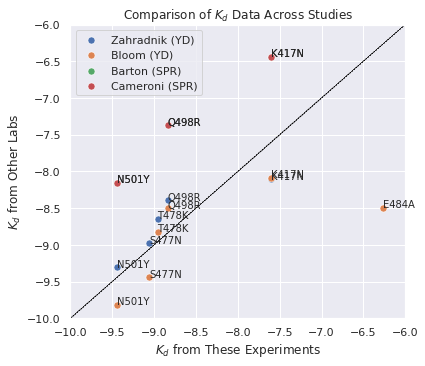

In [ ]:
sns.set(style="darkgrid", font_scale=1)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,6))
plt.subplots_adjust(hspace=0.3, wspace=0.1, bottom=0.2)

mutations = [x[0] for x in logkd_list]
mystudy_kd = [x[1] for x in logkd_list]
zahradnik_yd_kd = [7.82e-09, 1.05e-09, 2.28e-09, np.nan, 4.06e-09, 5.00e-10, np.nan, np.nan, np.nan]
bloom_yd_kd = [10**-8.085, 10**-9.439, 10**-8.822, 10**-8.495, 10**-8.503, 10**-9.814, np.nan, np.nan, np.nan]
barton_spr_kd = [3.64E-07, np.nan, np.nan, np.nan, 4.29E-08, 7.00E-09, np.nan, np.nan, np.nan]
cameroni_spr_kd = [1.97E-07, np.nan, 5.00E-08, np.nan, np.nan, 9.60E-09, np.nan, np.nan, np.nan]

def plot_correlation(mystudy, theirstudy, labels):

  study_data = pd.DataFrame({"mutation": mutations, "my_study": mystudy, "their_study": theirstudy})

  study_data.dropna(inplace=True)
  study_data.loc[:, "their_study"] = study_data.their_study.apply(np.log10, inplace=True)

  print(labels)
  print(study_data.to_string())

  sns.lineplot(x=[-15, 0], y=[-15, 0], color="black", linestyle="--", linewidth=0.5, ax=ax)

  sns.scatterplot(x="my_study", y="their_study", data=study_data, ax=ax, label=labels, s=50)

  ax.legend()

  plt.xlim([-10, -6])
  plt.ylim([-10, -6])

  plt.xlabel("$K_d$ from These Experiments")
  plt.ylabel("$K_d$ from Other Labs")

  for index, row in study_data.iterrows():
    ax.annotate(row["mutation"], (row["my_study"], row["their_study"]), fontsize = 10)

plot_correlation(mystudy_kd, zahradnik_yd_kd, "Zahradnik (YD)")
plot_correlation(mystudy_kd, bloom_yd_kd, "Bloom (YD)")
plot_correlation(mystudy_kd, barton_spr_kd, "Barton (SPR)")
plot_correlation(mystudy_kd, barton_spr_kd, "Cameroni (SPR)")

plt.title("Comparison of $K_d$ Data Across Studies")
plt.savefig("comparison_kd.png", dpi=600, bbox_inches='tight')